In [13]:
from dfencoder import AutoEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

sns.set()
%config InlineBackend.figure_format = 'retina'

In [15]:
with open('../Features_Dictionary', "r") as json_file:
    fd = json.load(json_file)
df = pd.read_pickle('../Odin/OldWithVerplid/Odin2019All')
len(df)
KHVM = False

cols = fd['FelyxKnown']
cols += fd['OTP']
cols += fd['Location']
cols += fd['Time']
#cols += fd['Comparison']
#cols += fd['PCInfo']
cols += fd['Weather']
if KHVM == True:
    cols += fd['Targets']
df = df[cols]

In [18]:
train = df.sample(frac=.8, random_state=42)
test = df.loc[~df.index.isin(train.index)]

X_train = train
X_val = test

model = AutoEncoder(
    encoder_layers = [512, 256, 5], #model architecture
    decoder_layers = [], #decoder optional - you can create bottlenecks if you like
    activation='relu',
    swap_p=0.2, #noise parameter
    lr = 0.01,
    lr_decay=.99,
    batch_size=512,
    logger='ipynb', #special logging for jupyter notebooks
    verbose=False,
    optimizer='sgd',
    scaler='gauss_rank', #gauss rank scaling forces your numeric features into standard normal distributions
    min_cats=3 #Define cutoff for minority categories, default 10
)

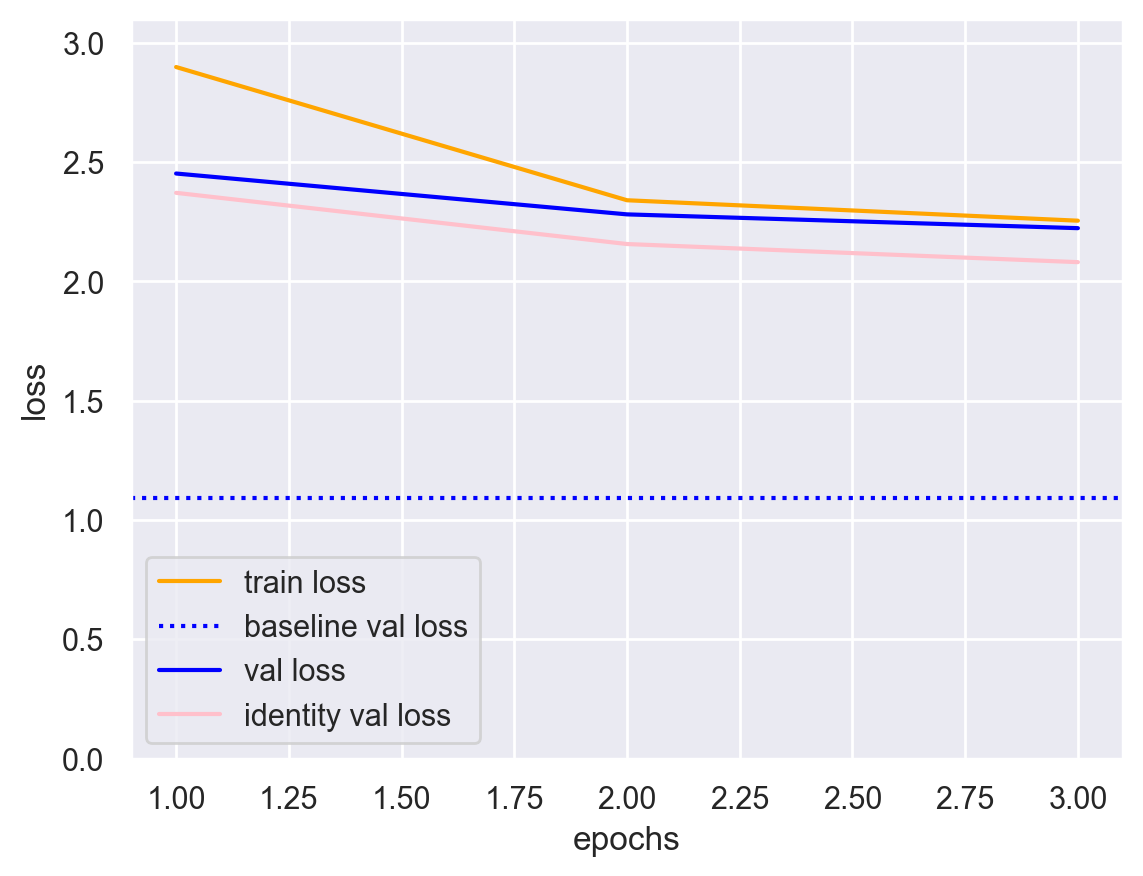

In [19]:
model.fit(X_train, epochs=3, val=X_val)

In [20]:
dimensionality = model.encoder_layers[2]
fulldim = sum(model.encoder_layers)

if KHVM == True:
    model.save('OldVerplid/WithKHVM/Odin/Model' + str(dimensionality))
else:
    model.save('OldVerplid/WithoutKHVM/Odin/Model' + str(dimensionality))

In [21]:
FullEmbeddingMatrix =model.get_deep_stack_features(df)
print(FullEmbeddingMatrix.shape)

EmbeddingMatrix = FullEmbeddingMatrix[:, -(dimensionality):].numpy()
df[['emb' + str(x) for x in range(dimensionality)]] = EmbeddingMatrix
fulldf = df.copy()
EmbeddingMatrix = FullEmbeddingMatrix.numpy()
fulldf[['emb' + str(x) for x in range(fulldim)]] = EmbeddingMatrix

if KHVM == True:
    df.to_pickle('OldVerplid/WithKHVM/Odin/E' + str(dimensionality))
    fulldf.to_pickle('OldVerplid/WithKHVM/Odin/E' + str(fulldim))
else:
    df.to_pickle('OldVerplid/WithoutKHVM/Odin/E' + str(dimensionality))
    fulldf.to_pickle('OldVerplid/WithoutKHVM/Odin/E' + str(fulldim))

torch.Size([192071, 773])


/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_35535/3307112651.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fulldf[['emb' + str(x) for x in range(fulldim)]] = EmbeddingMatrix
/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_35535/3307112651.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fulldf[['emb' + str(x) for x in range(fulldim)]] = EmbeddingMatrix
/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_35535/3307112651.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is u

In [8]:
Fel = pd.read_pickle('../FelyxData/FelyxModellingData/felyxotpAmsterdam')
Fel['hvm'] = ['Fiets'] * len(Fel)
Fel['khvm'] = ['Fiets'] * len(Fel)
Fel = Fel[list(set(Fel.columns).intersection(set(df.columns)))]
Felembs = model.get_deep_stack_features(Fel)
Felembs.shape

KeyError: 'leeftijd'

In [53]:
embs2 = Felembs[:, -(dimensionality):].numpy()
Fel[['emb' + str(x) for x in range(dimensionality)]] = embs2

fullFel = Fel.copy()
FelEmbeddingMatrix = Felembs.numpy()
fullFel[['emb' + str(x) for x in range(fulldim)]] = FelEmbeddingMatrix


if KHVM == True:
    Fel.to_pickle('OldVerplid/WithKHVM/Felyx/E' + str(dimensionality))
    fullFel.to_pickle('OldVerplid/WithKHVM/Felyx/E' + str(fulldim))
else:
    Fel.to_pickle('OldVerplid/WithoutKHVM/Felyx/E' + str(dimensionality))
    fullFel.to_pickle('OldVerplid/WithoutKHVM/Felyx/E' + str(fulldim))

/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_19046/3331714819.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fullFel[['emb' + str(x) for x in range(fulldim)]] = FelEmbeddingMatrix
/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_19046/3331714819.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fullFel[['emb' + str(x) for x in range(fulldim)]] = FelEmbeddingMatrix
/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_19046/3331714819.py:6: PerformanceWarning: DataFrame is highly fragmented.  T

In this case, we see that each row now has 1,536 new features associated with it. What can we do with them?
We could start by building a model predict the target feature, "salary".
### BUT WAIT!
Didn't we use salary to train the autoencoder? Won't we be cheating?<br><br>
Well, maybe. In a moment we'll see why that's not exactly important. Let's try to build a model anyway.

In [54]:
# X_train.salary.unique()
# X_train.khvm.unique()
X_train.columns#.unique()

Index(['choice_dur', 'choice_dist', 'oprijbewijsau', 'bike_dur', 'bike_dist',
       'car_dur', 'car_dist', 'pt_dur', 'pt_dist', 'walk_dur', 'walk_dist',
       'vertpc', 'aankpc', 'sin_time', 'cos_time', 'weekdag', 'feestdag',
       'aank Totaal', 'aank Man', 'aank Vrouw', 'aank tot 15 jaar',
       'aank 15 tot 25 jaar', 'aank 25 tot 45 jaar', 'aank 45 tot 65 jaar',
       'aank 65 jaar en ouder',
       'aank Geboren in Nederland met een Nederlandse herkomst',
       'aank Geboren in Nederland met een Europese herkomst (excl. Nederland)',
       'aank Geboren in Nederland met herkomst buiten Europa',
       'aank Geboren buiten Nederland met een Europese herkomst (excl. Nederland)',
       'aank Geboren buiten Nederland met een herkomst buiten Europa',
       'aank Totaal.1', 'aank Eenpersoons',
       'aank Meerpersoons \nzonder kinderen', 'aank Eenouder',
       'aank Tweeouder', 'aank Huishoudgrootte', 'aank Totaal.2',
       'aank voor 1945', 'aank 1945 tot 1965', 'aank 1965 to

In [55]:
from tqdm import tqdm_notebook as tqdm
dep_var = 'weekdag'#'khvm'
deptar = 'Zaterdag'#'Personenauto - bestuurder'

from sklearn.metrics import f1_score
import numpy as np
import torch
import tqdm

class ClassifierModel(torch.nn.Module):
    """A simple classifier neural network."""
  
    def __init__(self, *args, **kwargs):
        super(ClassifierModel, self).__init__(*args, **kwargs)
        self.input_dropout = torch.nn.Dropout(.1)
        self.input_layer = torch.nn.Linear(sum(model.encoder_layers), 512)
        self.dropout = torch.nn.Dropout(.5)
        self.dense = torch.nn.Linear(512, 512)
        self.output = torch.nn.Linear(512, 1)

    def forward(self, x):
        x = self.input_dropout(x)
        x = self.input_layer(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.relu(x)

        x = self.output(x)
        x = torch.sigmoid(x)
        return x
    
    
classifier = ClassifierModel()#.to("cuda:0")

optim = torch.optim.Adam(
    classifier.parameters(),
    weight_decay=.01
)

decay = torch.optim.lr_scheduler.ExponentialLR(optim, .99)

loss = torch.nn.modules.loss.BCELoss()

def do_step(classifier, optim, z, target, loss):
    pred = classifier(z)
    target = torch.tensor(target).float().reshape(-1, 1)#.to("cuda:0")
    loss_ = loss(pred, target)
    amnt = loss_.item()
    loss_.backward()
    optim.step()
    optim.zero_grad()
    return amnt

def do_evaluation(classifier, z, target, loss):
    with torch.no_grad():
        pred = classifier(z)
        probs = pred.cpu().numpy().reshape(-1)
        predictions = np.where(probs > .5, 1, 0)

        accuracy = np.where(target==predictions, 1, 0).sum()/len(predictions)
        f1 = f1_score(target, predictions)

        target_ = torch.tensor(target).float().reshape(-1, 1)#.to("cuda:0")
        loss_ = loss(pred, target_)
        return loss_.item(), accuracy, f1

  
batch_size = 256
n_updates = (len(X_train)//batch_size) + 1

n_epochs = 6

#To extract features, we'll set the target column on the input
#equal to the majority class: <50k

X_train2 = X_train.copy()
X_train2[dep_var] = [deptar for _ in X_train2[dep_var]]
z_train = model.get_deep_stack_features(X_train2)

Y_train = np.where(X_train[dep_var].values == deptar, 0, 1)

X_test2 = X_val.copy()
X_test2[dep_var] = [deptar for _ in X_test2[dep_var]]
z_test = model.get_deep_stack_features(X_test2)
Y_test = np.where(X_val[dep_var].values == deptar, 0, 1)

for j in range(n_epochs):
    if j % 5 == 0:
      print(f'{j} epochs complete...')
    for i in range(n_updates):
        step = i
        start = int((step) * batch_size)
        stop = int((step+1) * batch_size)
        in_ = z_train[start:stop]
        target = Y_train[start:stop]
        do_step(classifier, optim, in_, target, loss)
    decay.step()
    bce_loss, accuracy, f1 = do_evaluation(classifier, z_test, Y_test, loss)
print('\nFinal results: ')
print('validation loss: ', round(bce_loss, 4))
print('validation accuracy: ', round(accuracy, 3))
print('validation f1 score: ', round(f1, 3))

0 epochs complete...


KeyboardInterrupt: 

# How We Handled the Target
If you look at the above code, you'll see what we did to handle the target variable. We just set it to the majority class before inputting into the model - this gives us a test-agnostic way to encode our inputs for the classifier.<br><br>
Of course, the best way to deal with this is to omit the target from your autoencoder training in the first place, but this serves as an example of how we can get around the issue if we want to predict a variable that our autoencoder is expecting.

# Anomaly Detection
Another great application of DAE is anomaly detection. Here's an intuition on how this works:<br><br>
If we input a regular example, unaltered, into the DAE, we expect it to output a strong prediction for the input values. However, if the model sees an "unusual" example, it's going to be less certain. It may even return a strong prediction for different values than the input.<br><br>
We can measure this uncertainty as the loss against the input example against the model output. This value can be interpreted as an anomaly score.<br><br>
dfencoder AutoEncoders have a method to get this for you: .get_anomaly_score()

In [34]:
scores = model.get_anomaly_score(X_val)
X_val['anomaly_score'] = scores
X_val.sort_values('anomaly_score', ascending=False).head()

/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_19046/2595120113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['anomaly_score'] = scores


,choice_dur,choice_dist,oprijbewijsau,bike_dur,bike_dist,car_dur,car_dist,pt_dur,pt_dist,walk_dur,...,vert 2015 en later,vert Meergezins,vert Koopwoning,vert Huurwoning,vert Huurcoporatie,vert Niet bewoond,vert WOZ-waarde\nwoning,"vert Personen met WW, Bijstand en/of AO uitkering\nBeneden AOW-leeftijd",vert density,anomaly_score
verplid,,,,,,,,,,,,,,,,,,,,,
5906808820001,2700,54000,1,11305.0,52568.00,2464.0,51691.00,28043.0,71987.00,11305.0,...,0.053223,0.114813,0.005187,0.000206,0.034423,0.004536,0.000506,0.025705,0.144333,8.027779
5906165235201,3600,68000,1,12281.0,56724.00,3593.0,64390.00,12281.0,56724.00,12281.0,...,0.080895,0.021906,0.002603,0.000103,0.020808,0.002287,0.000238,0.042553,0.074643,7.858425
5902721829603,1500,26000,1,4333.0,20281.00,1355.0,23307.00,3635.0,28544.00,4333.0,...,0.012994,0.020433,0.008377,0.000748,0.049582,0.008754,0.000804,0.041220,0.021522,7.716766
5925437569405,2100,41000,1,5868.0,27823.00,2262.0,34601.00,29406.0,49670.00,5868.0,...,0.063024,0.056066,0.002295,0.000351,0.094933,0.007083,0.000247,0.034221,0.064651,7.545816
5602027077901,2400,50000,1,9409.0,44012.98,2502.0,48218.87,9409.0,44012.98,9409.0,...,0.010829,0.091297,0.002039,0.000312,0.063939,0.001982,0.000278,0.041443,0.130156,7.539700


If we look at the highest anomaly scores, we can try to guess about why these came out as anomalies. Alternatively, we can see what predictions the model made. Which brings us to the next application...
# Imputation
DAE are useful for imputation. To impute values, we can pass in an (incomplete) row and look at the model predictions; although the models train with a NaN value for categories, the .df_predict() method will return the maximum NON-NULL prediction as an imputed value. Let's see what the model outputs for the anomalous examples above:

In [35]:
imputed_values = model.df_predict(X_val.drop(columns='anomaly_score'))
imputed_values['anomaly_score'] = scores
imputed_values.sort_values('anomaly_score', ascending=False).head()


,choice_dur,choice_dist,oprijbewijsau,bike_dur,bike_dist,car_dur,car_dist,pt_dur,pt_dist,walk_dur,...,vert 2015 en later,vert Meergezins,vert Koopwoning,vert Huurwoning,vert Huurcoporatie,vert Niet bewoond,vert WOZ-waarde\nwoning,"vert Personen met WW, Bijstand en/of AO uitkering\nBeneden AOW-leeftijd",vert density,anomaly_score
verplid,,,,,,,,,,,,,,,,,,,,,
5906808820001,1200.0,6000.000000,1.0,1464.394531,5918.898926,1078.025513,7986.743164,2471.750977,9287.659180,4195.020996,...,0.019140,0.120507,0.001224,0.000409,0.104831,0.007275,0.000192,0.061767,0.148886,8.027779
5906165235201,1200.0,7378.143555,1.0,1302.219849,7695.584961,1174.640137,7569.046387,2503.405762,8501.223633,4250.904297,...,0.014125,0.128121,0.001146,0.000355,0.104433,0.007130,0.000239,0.063555,0.142515,7.858425
5902721829603,1500.0,6439.724121,1.0,1758.052856,7976.057129,1078.295654,7216.280762,2396.358398,8555.849609,4330.131348,...,0.013801,0.115140,0.001283,0.000386,0.103553,0.007309,0.000193,0.056129,0.154096,7.716766
5925437569405,1200.0,5500.000000,1.0,1422.572754,5958.640137,1037.255493,7515.868164,2437.830322,10181.071289,4191.104980,...,0.020240,0.112606,0.001243,0.000415,0.109757,0.007070,0.000182,0.059187,0.143736,7.545816
5602027077901,900.0,5000.000000,1.0,1326.932129,5274.745605,980.655029,7178.068848,2442.432861,12058.039062,4184.026367,...,0.024188,0.106040,0.001277,0.000444,0.117917,0.006573,0.000170,0.061763,0.139837,7.539700


Looking at the first row, apparently the country of origin, age, education-num, and fnlwgt values appear to be off. This feature may help us understand what's anomalous about the example.<br><br>
We also see imputed values!
# Exploratory Analysis
Sometimes, we just want to know more about our data. DAE can help us do this. <br><br>
Specifically, if you have any categorical variables in your dataframe, you can take a look at the category embeddings your model learned to represent different categories.<br><br>
Category embeddings are similar to word embeddings like word2vec in that they take sparse data (one-hot encoded categories) and convert them to compact, dense vectors. These are for the convenience of machine learning systems - humans don't interpret vectors very intuitively.<br><br>
However, one useful feature of category embeddings is category similarity. Given a category of interest, we can ask the model which categories are more similar, and which are less similar by looking at the cosine distance between embedding vectors.

In [36]:
from scipy.spatial.distance import cosine

def compare_category(model, feature, cat):
    """Ranks categories based on distance from category in question."""
    feature = model.categorical_fts[feature]
    cats = feature['cats'] + ['_other']
    scores = []
    this_cat = cats.index(cat)
    emb = feature['embedding']
    
    ft_embedding = emb.weight.data.cpu().numpy()[this_cat, :]
    
    for i, cat_ in enumerate(cats):
        vec = emb.weight.data.cpu().numpy()[i, :]
        similarity = cosine(ft_embedding, vec)
        scores.append(similarity)
        
    scrnm = f'distance from {cat}'
    result = pd.DataFrame(columns=['category', scrnm])
    result['category'] = cats
    result[scrnm] = scores
    
    print(result.sort_values(scrnm))
    
compare_category(model, 'weekdag', 'Zaterdag')

    category  distance from Zaterdag
5   Zaterdag                0.000000
7     _other                0.338487
3   Woensdag                0.397736
6     Zondag                0.926289
0    Vrijdag                0.939652
1  Donderdag                1.066288
2    Dinsdag                1.317727
4    Maandag                1.672421


In [37]:
#get a json-serialized record from our dataset.
record = df.sample().iloc[0].to_json()
print("In a production environment, we might see this data in json format:")
print(record)
#argument can be either a json string or a dict
z = model.get_deep_stack_features_json(record)
print('we get the deep stack features:')
print(z)
print(z.shape)

In a production environment, we might see this data in json format:
{"choice_dur":2700,"choice_dist":35000,"oprijbewijsau":1,"bike_dur":5260.0,"bike_dist":23425.0,"car_dur":2095.0,"car_dist":37598.75,"pt_dur":7305.0,"pt_dist":39591.6393981407,"walk_dur":5260.0,"walk_dist":23425.0,"vertpc":"5151","aankpc":"5081","sin_time":-0.9238795325,"cos_time":-0.3826834324,"weekdag":"Donderdag","feestdag":"Nee","aank Totaal":0.311551718,"aank Man":0.3628848347,"aank Vrouw":0.4342601526,"aank tot 15 jaar":0.1394574487,"aank 15 tot 25 jaar":0.0922293445,"aank 25 tot 45 jaar":0.1781891045,"aank 45 tot 65 jaar":0.2777080958,"aank 65 jaar en ouder":0.258979022,"aank Geboren in Nederland met een Nederlandse herkomst":0.0009607365,"aank Geboren in Nederland met een Europese herkomst (excl. Nederland)":0.0,"aank Geboren in Nederland met herkomst buiten Europa":0.0,"aank Geboren buiten Nederland met een Europese herkomst (excl. Nederland)":0.0,"aank Geboren buiten Nederland met een herkomst buiten Europa":0

/Users/joshuathomas/PycharmProjects/EmbeddedMobility/venv/lib/python3.9/site-packages/dfencoder/autoencoder.py:920: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  num = torch.tensor(numeric).reshape(1, -1).float().to(self.device)
